<font size="4">  
    ML 5642 Week 3 Assignment: CNN Cancer Detection
</font> 
<font size="3">  
    <ul>
        <li>Dataset is taken from <a href="https://www.kaggle.com/c/histopathologic-cancer-detection/data" target="_blank">Kaggle</a></li>
        <li>The goal of this project is to accurately identify metastatic cancer in small image patches taken from larger digital pathology scans</li>
    </ul>
</font>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

EDA: Connect to data source and inspect/visualize data. Add the file extension to the image files.

In [2]:
# connect to Kaggle dataset and display contents
train_images = '/kaggle/input/histopathologic-cancer-detection/train/'
test_images = '/kaggle/input/histopathologic-cancer-detection/test/'

df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df['id'] = df['id'] + '.tif'
df['label'] = df['label'].astype(str)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


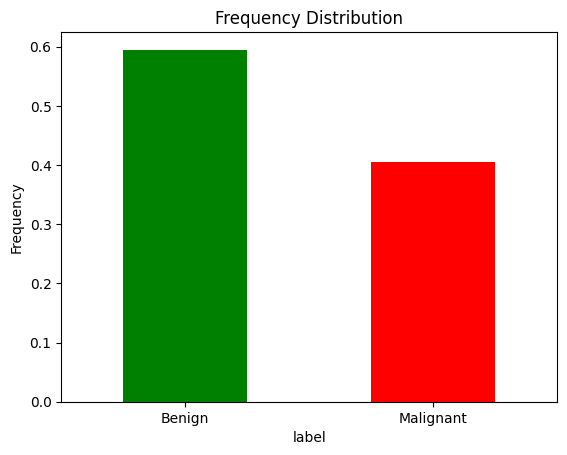

In [3]:
# get frequency distribution
distribution = (df.label.value_counts() / len(df)).to_frame()
distribution.iloc[:, 0].plot(kind='bar', color=['green', 'red'])
plt.title('Frequency Distribution')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Benign', 'Malignant'], rotation=0)
plt.show()

In [4]:
# split the data into training and validation data
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# get size of each dataset
print("training size: ", len(train_df))
print("validation size: ", len(valid_df))

training size:  176020
validation size:  44005


In [5]:
train_data = ImageDataGenerator(rescale=1/255,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,zoom_range=0.1)
valid_data = ImageDataGenerator(rescale=1/255)

In [6]:
train_loader = valid_data.flow_from_dataframe(
    dataframe=train_df,
    directory=train_images,
    x_col='id',
    y_col='label',
    class_mode='categorical',
    batch_size=64,
    target_size=(32, 32),
    shuffle=False
)

valid_loader = valid_data.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_images,
    x_col='id',
    y_col='label',
    class_mode='categorical',
    batch_size=64,
    target_size=(32, 32),
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Using a CNN model because of its strong performance for images. Hyperparameter tune by adjusting learning rate.

In [ ]:
cnn = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(2, activation='softmax')
])

cnn.summary() #display summary results

optimizer = Adam(learning_rate=0.0001) #this can be hypertuned
cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[AUC(name='auc')])
history = cnn.fit(train_loader,validation_data=valid_loader,epochs=25,verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,720,834 (6.56 MB)

 Trainable params: 1,718,146 (6.55 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 358/2751 ━━━━━━━━━━━━━━━━━━━━ 15:26 387ms/step - auc: 0.7199 - loss: 1.3779

In [ ]:
# visuals for training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['auc'])), history.history['auc'], label='Training AUC')
plt.plot(range(len(history.history['auc'])), history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(range(len(history.history['auc'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['auc'])), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


As we can see as we go through the training data the accuracy starts to go down and the loss starts to increase. In the future I would attempt to see if there are better steps I could take to help clean the images before running them through the model. Perhaps maintaining some sort of uniformity.